In [315]:
# Main notebook for the project
import requests
import warnings
from bs4 import BeautifulSoup
import os
import re
import pandas as pd
from urllib.parse import urljoin
import shutil
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

def create_folder_if_not_exists(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

def save_dataset(df, folder, file_name):
    create_folder_if_not_exists(folder)
    file_path = os.path.join(folder, file_name)
    df.to_csv(file_path, index=False)

def download_file(url, folder):
    file_name = url.split('/')[-1]
    file_path = os.path.join(folder, file_name)
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")        

def find_data_start_row(file_path):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if line.startswith("   "):
                return i
    return 0

def extract_links(url, href_contains):
    urls = []
    try:
        response = requests.get(url)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = soup.find_all('a', href=True)
            for link in links:
                if href_contains in link['href']:
                    full_url = urljoin(url, link['href'])
                    urls.append(full_url)
        else:
            print(f"Error accessing page: Status code {response.status_code}")
    except requests.RequestException as e:
        print(f"Error during requests to {url} : {str(e)}")
    
    return urls

def download_main_dataset(url, output_folder, pattern):
    timestamp_suffix = datetime.now().strftime("_%Y%m%d_%H%M%S")
    output_folder_with_timestamp = f"{output_folder}{timestamp_suffix}"
    csv_links = extract_links(url, pattern)
    create_folder_if_not_exists(output_folder_with_timestamp)

    for link in csv_links:
        # Pass the modified folder path with the timestamp to the download function
        download_file(link, output_folder_with_timestamp)
        
def txt_to_csv(file_path, output_folder):    #Dataset 1
    start_row = find_data_start_row(file_path)
    df = pd.read_csv(file_path, skiprows=start_row, delim_whitespace=True, usecols=[0, 1, 2, 3, 4, 5, 6])
    df.reset_index(drop=True, inplace=True)
    file_name = os.path.basename(file_path)
    output_file = os.path.join(output_folder, file_name.replace('.txt', '.csv'))
    df.to_csv(output_file, index=False)
    return output_folder

def convert_txts_to_csvs(input_folder, output_folder):    #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file)
        if file_path.endswith('.txt'):
            txt_to_csv(file_path, output_folder)

def clean_and_rename_csv_in_folder(input_folder, output_folder, remove_rows_criteria=[], special_chars_to_remove=[]):   #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df = df.drop(0).reset_index(drop=True)
            df.columns = ['yyyy', 'mm', 'tmax (degC)', 'tmin (degC)', 'af (days)', 'rain (mm)', 'sun (hours)']
            df.replace('---', pd.NA, inplace=True)
            for criterion in remove_rows_criteria:
                for col_name, value in criterion.items():
                    df = df[df[col_name] != value]
            for col in df.columns:
                if df[col].dtype == 'object':
                    for char in special_chars_to_remove:
                        df[col] = df[col].str.replace(char, "", regex=True)
            output_file_path = os.path.join(output_folder, file_name)
            df.to_csv(output_file_path, index=False)

def extract_and_save_coordinates(input_folder, output_folder):  #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.txt'):
            with open(file_path, 'r') as file:
                text = file.read()
            lat_lon_pattern = re.compile(r'Lat\s*([+-]?\d+\.\d+)\s*Lon\s*([+-]?\d+\.\d+)')
            matches = lat_lon_pattern.findall(text)
            if matches:
                latest_lat, latest_lon = matches[-1]
            else:
                latest_lat, latest_lon = None, None
            df = pd.DataFrame({
                'Station': [file_name.replace("data.txt", "")],
                'Latitude': [latest_lat],
                'Longitude': [latest_lon]
            })
            output_file_name = os.path.splitext(file_name)[0].replace("data", "") + '_coordinates.csv'
            output_file_path = os.path.join(output_folder, output_file_name)
            df.to_csv(output_file_path, index=False)

def process_happiness_excel(file_path, sheet_name, word):   #Dataset 2
    # Load the CSV data, ignoring the first column which is just an index
    data = pd.read_excel(file_path, sheet_name=sheet_name, header=None, skiprows=2)

    col_names = [
        "Codes", "Area names", "Region", "Location", "Total % 0-4", "Total % 5-6", "Total % 7-8", "Total % 9-10", 
        "Total Average rating", "Total Standard deviation", "0-4 CV", "0-4 Lower limit", "0-4 Upper limit", 
        "5-6 CV", " 5-6 Lower limit", "5-6 Upper limit", "7-8 CV", "7-8 Lower limit", "7-8 Upper limit", 
        "9-10 CV", "9-10 Lower limit", "9-10 Upper limit", "Total CV", "Total Lower limit", "Total Upper limit", 
        "Sample size"
    ]
    for i in range(len(data)):
        if word in str(data.iloc[i, 0]):
            data.columns = data.iloc[i]
            data = data.iloc[i+1:]
            break
    data = data.dropna(how="all")
    data.reset_index(drop=True, inplace=True)
    data.columns = data.columns.str.strip()
    if "2012" in file_path:
        new_columns = col_names
    else:
        del col_names[9]
        new_columns = col_names
    data.columns = new_columns[:len(data.columns)]

    return data

def process__excel_folder(input_folder, output_folder, sheet_name, word):   #Dataset 2
    create_folder_if_not_exists(output_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith(".xls"):
            file_path = os.path.join(input_folder, filename)
            updated_filename = filename[:-3] + "xlsx"
            updated_file_path = os.path.join(input_folder, updated_filename)
            shutil.copy(file_path, updated_file_path)
            updated_file_path = os.path.join(input_folder, updated_filename)
            processed_data = process_happiness_excel(updated_file_path, sheet_name, word)
            output_file_path = os.path.join(output_folder, filename.replace(".xls", ".csv"))
            processed_data.to_csv(output_file_path, index=False)

def clean_census_rows(input_folder, output_folder):   #Dataset 2
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df = df[~df['Codes'].str.contains(' ', na=True)]
            df.replace('x', np.nan, inplace=True)
            df.replace('#', np.nan, inplace=True)
            df.replace('x ', np.nan, inplace=True)
            output_file_path = os.path.join(output_folder, file_name)
            df.to_csv(output_file_path, index=False)

def combine_dataset_2_average(input_folder, output_folder, drop_columns=["Total Standard deviation"], no_group=False):
    all_codes_dfs = []
    
    # Step 1: Collect 'Codes' from each file
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            df.replace('x', np.nan, inplace=True)
            all_codes_dfs.append(df[['Codes']].drop_duplicates())
    
    # Step 2: Find distinct 'Codes'
    distinct_codes_df = pd.concat(all_codes_dfs).drop_duplicates().reset_index(drop=True)
    
    all_data_dfs = []
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            df.replace('x', np.nan, inplace=True)
            df = df.drop(columns=drop_columns, errors='ignore')
            all_data_dfs.append(df)
    
    # Concatenate all DataFrames vertically and sort by 'Codes'
    concatenated_df = pd.concat(all_data_dfs, axis=0).sort_values(by='Codes')
    concatenated_df["Sample size"] = concatenated_df["Sample size"].astype(float)

    # If no_group is True, skip the grouping and averaging process
    if no_group:
        final_df = concatenated_df
    else:
        # Step 5: Compute final values based on your criteria
        def compute_final_values(group):
            numeric_cols = group.select_dtypes(include=np.number).columns
            non_numeric_cols = group.select_dtypes(exclude=np.number).columns.drop('Codes')

            # For numeric columns, calculate mean
            group[numeric_cols] = group[numeric_cols].mean()

            # For non-numeric columns, keep the first value
            group[non_numeric_cols] = group[non_numeric_cols].apply(lambda x: x.dropna().head(1).item() if not x.dropna().empty else np.nan)

            return group.head(1)

        final_df = concatenated_df.groupby('Codes', as_index=False).apply(compute_final_values).reset_index(drop=True)

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define the output file path within the output folder
    output_file_path = os.path.join(output_folder, "combined_dataset.csv" if not no_group else "merged_dataset.csv")

    # Save the final DataFrame
    final_df.to_csv(output_file_path, index=False)

def impute_missing_values(file_path, columns_to_impute, group_by=None):
    df = pd.read_csv(file_path)
    
    if group_by:
        for col in columns_to_impute:
            df[col] = df.groupby(group_by)[col].transform(lambda x: x.fillna(x.mean()))
    else:
        for col in columns_to_impute:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

def impute_missing_values_in_folder(input_folder, output_folder, columns_to_impute, group_by=None):
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            try:
                df = impute_missing_values(file_path, columns_to_impute, group_by)
                output_file_path = os.path.join(output_folder, file_name)
                df.to_csv(output_file_path, index=False)
            except Exception as e:
                print(f"Error occurred in file: {file_name}")
                print(str(e))

def generate_weather_dataset(input_folder, use_station_average=True, drop_rows_criteria=["stations_total_average"]):
    all_data = []

    # Step 1: Concatenate all CSVs with a 'station' column
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            station_name = os.path.splitext(file_name)[0].replace("data", "")
            temp_df = pd.read_csv(os.path.join(input_folder, file_name))
            temp_df['station'] = station_name
            all_data.append(temp_df)

    # Combine into one DataFrame
    df_combined = pd.concat(all_data, ignore_index=True)
    
    # Ensure numeric columns are treated as such
    numeric_cols = ['tmax (degC)', 'tmin (degC)', 'af (days)', 'rain (mm)', 'sun (hours)']
    df_combined[numeric_cols] = df_combined[numeric_cols].apply(pd.to_numeric, errors='coerce')

    if use_station_average:
        # Step 2: Group by 'station' and calculate averages
        df_result = df_combined.groupby('station')[numeric_cols].mean().reset_index()
    else:
        # Step 3: Group by 'station', 'yyyy', and 'mm' then calculate averages
        df_result = df_combined.groupby(['station', 'mm'])[numeric_cols].mean().reset_index()
    df_result = df_result.drop(df_result[df_result['station'].isin(drop_rows_criteria)].index)
    return df_result

def find_elbow_point(wcss):
    # Calculate the second derivative of the wcss list
    second_derivative = np.diff(wcss, n=2)
    # The elbow point is where the second derivative is maximum (in absolute value)
    elbow_point = np.argmax(np.abs(second_derivative)) + 2  # Adding 2 because np.diff reduces the length by 1 for each differentiation
    return elbow_point

def apply_clustering(df, num_clusters_range, optimal_num_clusters=None):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numerical_cols]
    
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for n_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X_scaled)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        
        if n_clusters > 1:  # These metrics require at least 2 clusters to be meaningful
            silhouette_scores.append(silhouette_score(X_scaled, labels))
            davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

    # Visualizing the metrics to help determine the optimal number of clusters
    plt.figure(figsize=(18, 5))
    
    # Plot WCSS
    plt.subplot(1, 3, 1)
    plt.plot(num_clusters_range, wcss, marker='o', linestyle='-', color='blue')
    plt.title('Elbow Method (WCSS)')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
    # Plot Silhouette Score
    plt.subplot(1, 3, 2)
    plt.plot(num_clusters_range[1:], silhouette_scores, marker='o', linestyle='-', color='green')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
    # Plot Davies-Bouldin Score
    plt.subplot(1, 3, 3)
    plt.plot(num_clusters_range[1:], davies_bouldin_scores, marker='o', linestyle='-', color='red')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Score')
    
    plt.tight_layout()
    plt.show()

    optimal_num_clusters = optimal_num_clusters if optimal_num_clusters else find_elbow_point(wcss)

    # Apply clustering with the chosen optimal number of clusters
    kmeans_optimal = KMeans(n_clusters=optimal_num_clusters, random_state=42, n_init=10).fit(X_scaled)
    df['cluster'] = kmeans_optimal.labels_
    
    return df

def add_coordinates_to_df(df, locations_folder, join_on):
    locations_df = pd.DataFrame()

    # Concatenate all location files into one DataFrame
    for file_name in os.listdir(locations_folder):
        if file_name.endswith('.csv'):
            # Read the coordinates file
            temp_df = pd.read_csv(os.path.join(locations_folder, file_name))
            # Concatenate to the main locations DataFrame
            locations_df = pd.concat([locations_df, temp_df], ignore_index=True)

    # Ensure there are no duplicate columns in the locations DataFrame before merging
    locations_df = locations_df.drop_duplicates(subset=join_on[1])

    # Merge the main df with the locations DataFrame on the specified columns
    df_with_coords = df.merge(locations_df, how='left', left_on=join_on[0], right_on=join_on[1])

    return df_with_coords

def plot_clusters_on_map(df, map_col='cluster', lat_col='Latitude', lon_col='Longitude'):
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]))

    # Define the bounds for the UK (these are approximate and may need adjusting)
    uk_bounds = {
        "min_lon": -10.5, "max_lon": 1.8,
        "min_lat": 49.8, "max_lat": 60.9
    }

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    uk = world.cx[uk_bounds["min_lon"]:uk_bounds["max_lon"], uk_bounds["min_lat"]:uk_bounds["max_lat"]]
    uk.plot(ax=ax, color='white', edgecolor='black')

    # Plot the clusters
    gdf.plot(ax=ax, markersize=50, column=map_col, legend=True, cmap='viridis')

    # Annotate each point with its cluster label
    for idx, row in gdf.iterrows():
        ax.annotate(text=row[map_col], xy=(row[lon_col], row[lat_col]),
                    xytext=(3,3), # Position label slightly off of the point
                    textcoords="offset points", # Offset (3,3) points
                    fontsize=8, color='darkred')

    # Set axis limits to zoom in to the UK
    ax.set_xlim(uk_bounds["min_lon"], uk_bounds["max_lon"])
    ax.set_ylim(uk_bounds["min_lat"], uk_bounds["max_lat"])

    plt.show()

def plot_cluster_distribution_on_map(df, lat_col='Latitude', lon_col='Longitude', cluster_col='cluster'):
    # Aggregate data by location and cluster and count the occurrences
    agg_df = df.groupby([lat_col, lon_col, cluster_col]).size().reset_index(name='counts')

    # Calculate the total counts by location
    total_counts = agg_df.groupby([lat_col, lon_col])['counts'].sum().reset_index(name='total_counts')

    # Merge back to get the total counts per location
    agg_df = agg_df.merge(total_counts, on=[lat_col, lon_col])

    # Calculate the percentage of each cluster at each location
    agg_df['percentage'] = (agg_df['counts'] / agg_df['total_counts'] * 100).round(2)
    
    # Create labels for plotting
    agg_df['label'] = 'C' + agg_df[cluster_col].astype(str) + ': ' + agg_df['percentage'].astype(str) + '%'
    labels_df = agg_df.groupby([lat_col, lon_col])['label'].apply(list).reset_index(name='labels')

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        labels_df, 
        geometry=gpd.points_from_xy(labels_df[lon_col], labels_df[lat_col])
    )

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    # Define the bounds for the UK
    uk_bounds = {"min_lon": -10.5, "max_lon": 1.8, "min_lat": 49.8, "max_lat": 60.9}
    ax.set_xlim(uk_bounds["min_lon"], uk_bounds["max_lon"])
    ax.set_ylim(uk_bounds["min_lat"], uk_bounds["max_lat"])

    # Plot each location with its cluster distribution label
    for idx, row in gdf.iterrows():
        ax.scatter(row.geometry.x, row.geometry.y, color='blue', alpha=0.6, edgecolor='black')
        ax.text(row.geometry.x, row.geometry.y, ' | '.join(row['labels']), fontsize=4.5,  # Adjusted fontsize here
                verticalalignment='bottom', horizontalalignment='right')
    
    plt.show()

def determine_dominant_cluster_manual(df, lat_col='Latitude', lon_col='Longitude', cluster_col='cluster'):
    # Group the DataFrame by latitude and longitude
    grouped = df.groupby([lat_col, lon_col])

    # Initialize a list to hold the data for the dominant cluster DataFrame
    dominant_clusters_data = []

    # Iterate through each group
    for (lat, lon), group in grouped:
        # Calculate the most frequent cluster for this group
        most_frequent_cluster = group[cluster_col].mode()[0]  # mode()[0] ensures we're getting the first mode in case of ties

        # Calculate the count of the most frequent cluster
        count = group[group[cluster_col] == most_frequent_cluster].shape[0]

        # Append the information to our list
        dominant_clusters_data.append({
            lat_col: lat,
            lon_col: lon,
            'dominant_cluster': most_frequent_cluster,
            'count': count
        })

    # Create a DataFrame from the collected data
    dominant_clusters_df = pd.DataFrame(dominant_clusters_data)

    return dominant_clusters_df

def apply_dbscan_clustering(df, eps=0.8, min_samples=5):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numerical_cols]
    
    # Scale the data
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
    labels = dbscan.labels_
    
    # Add the cluster labels to the dataframe
    df['cluster'] = labels
    
    # Calculate silhouette and Davies-Bouldin scores for the clustering
    # Note: These scores require more than one cluster to be meaningful, 
    # excluding noise points labeled as -1 by DBSCAN.
    if len(set(labels)) > 2:  # More than 1 cluster excluding noise
        silhouette_avg = silhouette_score(X_scaled, labels)
        davies_bouldin_avg = davies_bouldin_score(X_scaled, labels)
        print(f"Silhouette Score: {silhouette_avg}")
        print(f"Davies-Bouldin Score: {davies_bouldin_avg}")
    else:
        print("Not enough clusters to calculate silhouette and Davies-Bouldin scores.")
    
    return df

def generate_latitude_ds(df, number_groups):
    df['lat_group'] = pd.qcut(df['Latitude'], q=number_groups, labels=False)
    return df

def classify_latitude_groups(df, testing_fraction, target_column):
    # Prepare the features and target variable
    X = df.drop(columns=[target_column, 'Latitude', 'station'])  # Exclude non-feature columns
    y = df[target_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_fraction, random_state=42)
    print(X_test)
    
    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    
    # Predict the classes for the test set
    y_pred = model.predict(X_test)
    
    # Create a DataFrame with actual and predicted classes for the test set
    test_results_df = X_test.copy()
    test_results_df['Actual_Class'] = y_test
    test_results_df['Predicted_Class'] = y_pred
    
    # Optionally: calculate the accuracy of the predictions
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")

    return test_results_df

Dataset 1 Download and Schema Enforcement

In [237]:
# Download and convert the files for dataset 1
output_folder_ds1_txt = '../data/ds1/landing/stations_txt'
output_folder_ds1_csv = '../data/ds1/landing/stations_csv'
output_folder_ds1_csv_clean = '../data/ds1/bronze/stations_csv_clean'
station_url = 'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data'
pattern_station = '.txt'

download_main_dataset(station_url, output_folder_ds1_txt, pattern_station)
convert_txts_to_csvs(output_folder_ds1_txt, output_folder_ds1_csv)
clean_and_rename_csv_in_folder(output_folder_ds1_csv, output_folder_ds1_csv_clean, [{'yyyy': "Site"}], ['#', '\*', 'Change', '\$', 'all'])

# Extract and save coordinates
output_folder_ds1_coordinates = '../data/ds1/reference/locations'
extract_and_save_coordinates(output_folder_ds1_txt, output_folder_ds1_coordinates)

Dataset 2 Download and Schema Enforcement

In [91]:
# Download and convert the files for dataset 2
output_folder_ds2_xlsx = '../data/ds2/landing/census_xlsx'
output_folder_ds2_csv = '../data/ds2/landing/census_csv'
output_folder_ds2_csv_clean = '../data/ds2/bronze/census_csv_clean'
output_folder_ds2_csv_combined ='../data/ds2/bronze/census_csv_combined'
census_url = "https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/personalwellbeingestimatesgeographicalbreakdown"
pattern_census = 'tcm'
create_folder_if_not_exists(output_folder_ds2_csv_combined)
download_main_dataset(census_url, output_folder_ds2_xlsx, pattern_census)
process__excel_folder(output_folder_ds2_xlsx, output_folder_ds2_csv, 'Happiness', 'Codes')
clean_census_rows(output_folder_ds2_csv, output_folder_ds2_csv_clean)
combine_dataset_2_average(output_folder_ds2_csv_clean, output_folder_ds2_csv_combined, no_group=False)

Datset 1 Impute Missing Values

In [207]:
output_folder_ds1_csv_clean = '../data/ds1/bronze/stations_csv_clean'
output_folder_ds1_csv_clean_imputed = '../data/ds1/silver/stations_csv_clean_imputed'
columns_to_impute = ["mm", "tmax (degC)", "tmin (degC)", "af (days)", "rain (mm)", "sun (hours)"]

impute_missing_values_in_folder(output_folder_ds1_csv_clean, output_folder_ds1_csv_clean_imputed, columns_to_impute, group_by="mm")

Part 1

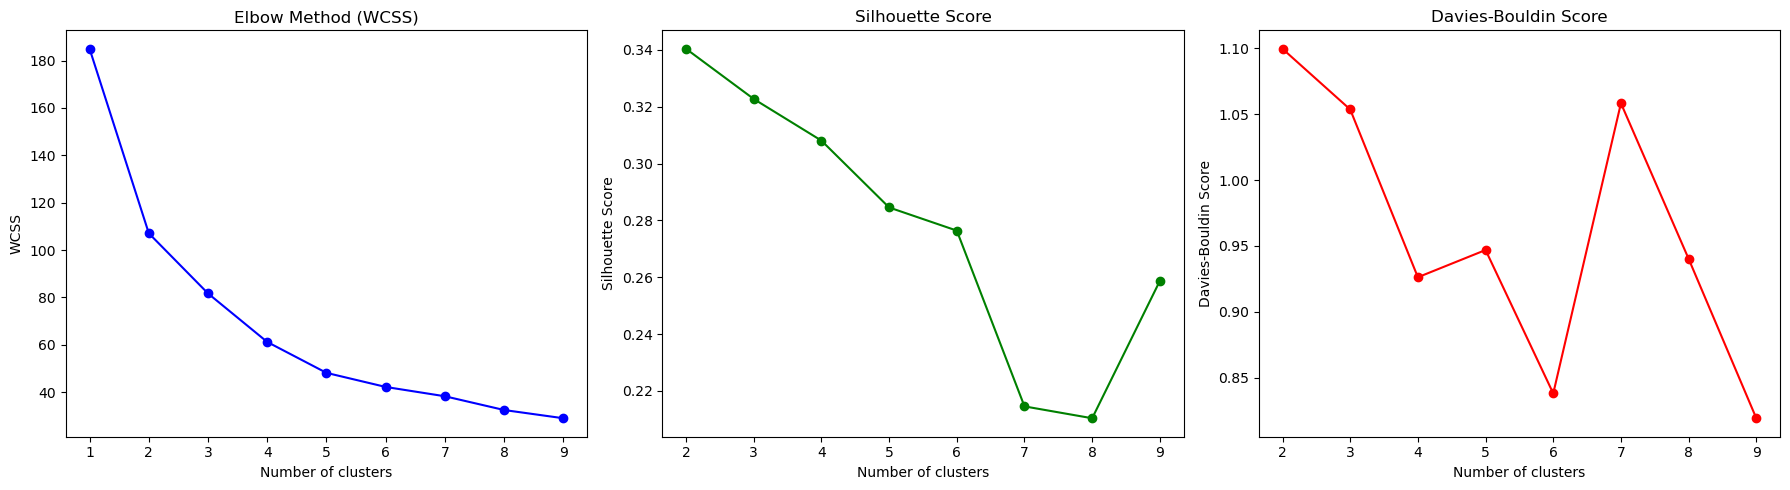

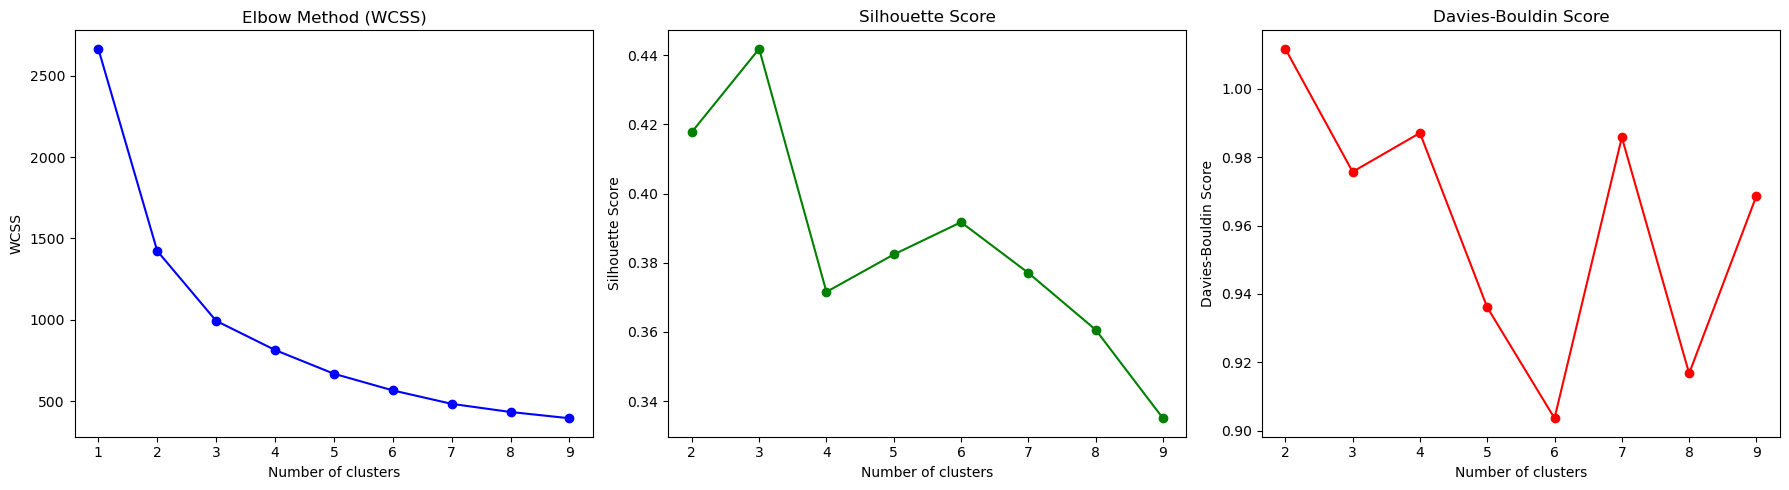

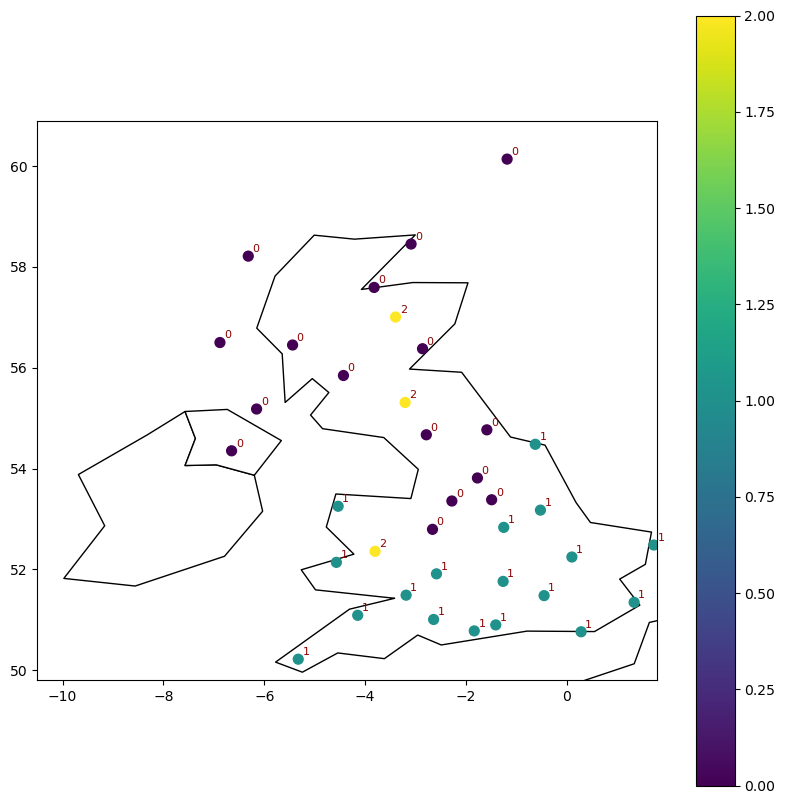

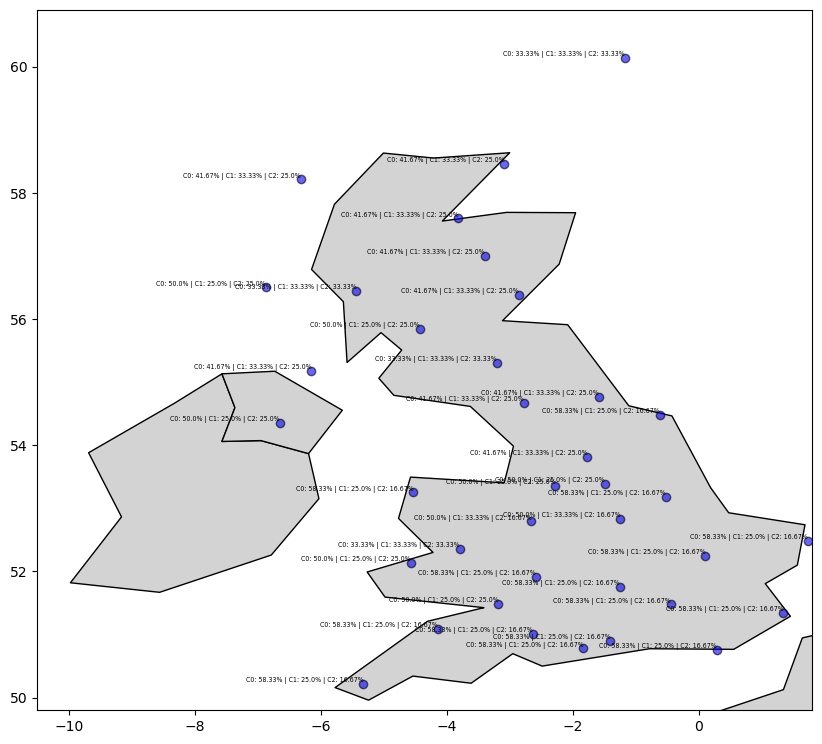

Not enough clusters to calculate silhouette and Davies-Bouldin scores.


In [316]:
output_folder_ds1_csv_clean_imputed = '../data/ds1/silver/stations_csv_clean_imputed'
output_folder_ds1_coordinates = '../data/ds1/reference/locations'

output_folder_clustering_df = '../data/ds1/silver/clustering_datasets'

output_folder_clustering_df_labeled = '../data/ds1/silver/clustering_datasets_labeled'

stations_total_average_file_name = 'stations_total_average_kmeans.csv'
stations_total_average_labeled_file_name = 'stations_total_average_kmeans.csv'
stations_total_average_labeled_file_name_dbscnan = 'stations_total_average_dbscan.csv'

stations_monthly_file_name = 'stations_monthly_average_kmeans.csv'
stations_monthly_labeled_file_name = 'stations_monthly_average_kmeans.csv'
stations_monthly_file_name_manual = 'stations_monthly_average_manual_kmeans.csv'


stations_total_average_df = generate_weather_dataset(output_folder_ds1_csv_clean_imputed, use_station_average=True)
stations_monthly_average_df = generate_weather_dataset(output_folder_ds1_csv_clean_imputed, use_station_average=False)

save_dataset(stations_total_average_df, output_folder_clustering_df, stations_total_average_file_name)
save_dataset(stations_monthly_average_df, output_folder_clustering_df, stations_monthly_file_name)

stations_total_average_df_labeled = apply_clustering(stations_total_average_df, range(1, 10), optimal_num_clusters=3)
stations_monthly_average_df_labeled = apply_clustering(stations_monthly_average_df, range(1, 10), optimal_num_clusters=3)

stations_total_average_df_labeled = add_coordinates_to_df(stations_total_average_df_labeled, output_folder_ds1_coordinates, ['station', 'Station']).drop(columns=['Station'])
stations_monthly_average_df_labeled = add_coordinates_to_df(stations_monthly_average_df_labeled, output_folder_ds1_coordinates, ['station', 'Station']).drop(columns=['Station'])


save_dataset(stations_total_average_df_labeled, output_folder_clustering_df_labeled, stations_total_average_labeled_file_name)
save_dataset(stations_monthly_average_df_labeled, output_folder_clustering_df_labeled, stations_monthly_labeled_file_name)

stations_monthly_average_df_labeled_manual = determine_dominant_cluster_manual(stations_monthly_average_df_labeled[['Latitude', 'Longitude', 'cluster']])
save_dataset(stations_monthly_average_df_labeled_manual, output_folder_clustering_df_labeled, stations_monthly_file_name_manual)

plot_clusters_on_map(stations_total_average_df_labeled)
plot_cluster_distribution_on_map(stations_monthly_average_df_labeled)

stations_total_average_df_dbscan = apply_dbscan_clustering(stations_total_average_df)
save_dataset(stations_total_average_df_dbscan, output_folder_clustering_df_labeled, stations_total_average_labeled_file_name_dbscnan)

Part 2

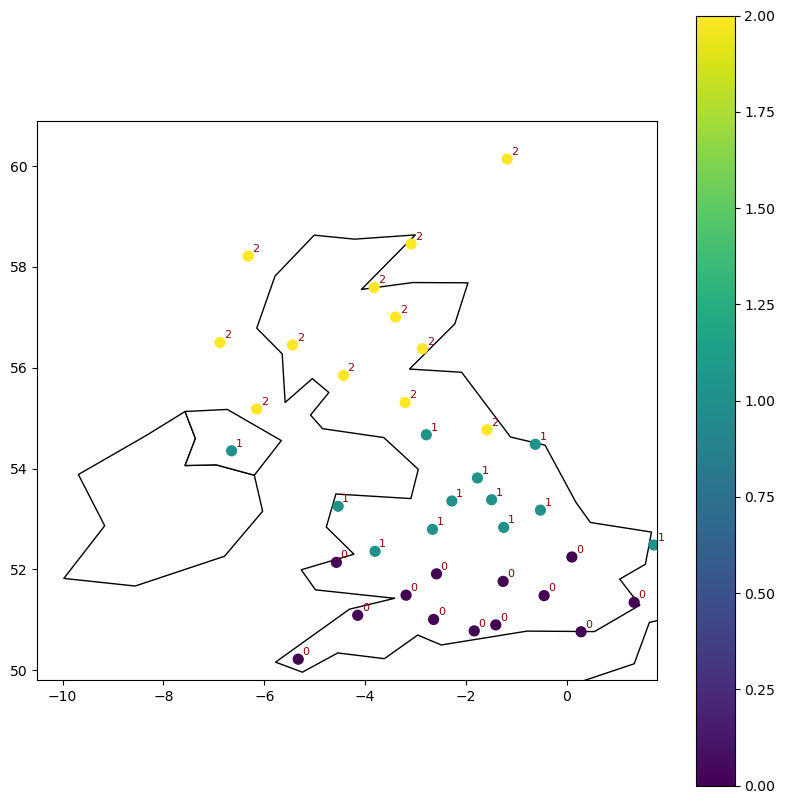

    tmax (degC)  tmin (degC)  af (days)   rain (mm)  sun (hours)  Longitude
17    12.339702     5.019231   4.919355   57.429404   123.625682     -2.861
13    10.972860     3.467795   7.168458  135.532990    97.279904     -3.206
4     10.591872     2.793069   8.622043   75.829173    98.560782     -3.396
29    11.020585     5.377820   2.762366  100.450304   100.615642     -6.318
35    10.525007     5.038453   3.561327   65.127837   104.501479     -3.088
25    14.075961     6.271761   3.731903   60.335121   123.986863     -2.584
6     14.365857     6.251790   3.563939   46.490851   124.819788      0.102
26    13.520797     5.373336   4.934252   55.958635   114.927509     -2.663
Model Accuracy: 0.625
       mm  tmax (degC)  tmin (degC)  af (days)   rain (mm)  sun (hours)  \
334  11.0     9.207971     4.298551   2.485507   79.982270    51.169474   
137   6.0    17.772917     8.484028   0.034722   50.868056   172.485455   
72    1.0     7.043939     1.368182  10.272727   45.753125    55.2846

In [323]:
stations_total_labeled_file_name = stations_total_average_df_labeled
stations_monthly_labeled_file_name = stations_monthly_average_df_labeled
output_folder_labeled_latitude = '../data/ds1/silver/latitude_label/'
create_folder_if_not_exists(output_folder_labeled_latitude)

latitude_total_dataset = "latitude_total_dataset.csv"
latitude_monthly_dataset = "latitude_monthly_dataset.csv"

stations_latitutde_total_average_df = generate_latitude_ds(stations_total_labeled_file_name, 3).drop(columns=['cluster'])

save_dataset(stations_latitutde_total_average_df, output_folder_labeled_latitude, latitude_total_dataset)
plot_clusters_on_map(stations_latitutde_total_average_df, map_col='lat_group')

stations_latitude_monthly_average_df = generate_latitude_ds(stations_monthly_labeled_file_name, 3).drop(columns=['cluster'])
save_dataset(stations_latitutde_total_average_df, output_folder_labeled_latitude, latitude_monthly_dataset)

testing_fraction = 0.2  # 20% of the data for testing
target_column = 'lat_group'

# Assuming stations_latitutde_total_average_df is your DataFrame ready with 'Latitude' and 'lat_group' columns
classified_df_total = classify_latitude_groups(stations_latitutde_total_average_df, testing_fraction, target_column)
classified_df_monthly = classify_latitude_groups(stations_latitude_monthly_average_df, testing_fraction, target_column)


In [326]:
classified_df_total

,tmax (degC),tmin (degC),af (days),rain (mm),sun (hours),Longitude,Actual_Class,Predicted_Class
17,12.339702,5.019231,4.919355,57.429404,123.625682,-2.861,2,1
13,10.972860,3.467795,7.168458,135.532990,97.279904,-3.206,2,1
4,10.591872,2.793069,8.622043,75.829173,98.560782,-3.396,2,1
29,11.020585,5.377820,2.762366,100.450304,100.615642,-6.318,2,2
35,10.525007,5.038453,3.561327,65.127837,104.501479,-3.088,2,2
25,14.075961,6.271761,3.731903,60.335121,123.986863,-2.584,0,0
6,14.365857,6.251790,3.563939,46.490851,124.819788,0.102,0,0
26,13.520797,5.373336,4.934252,55.958635,114.927509,-2.663,1,1


In [327]:
classified_df_monthly

,mm,tmax (degC),tmin (degC),af (days),rain (mm),sun (hours),Longitude,Actual_Class,Predicted_Class
334,11.0,9.207971,4.298551,2.485507,79.982270,51.169474,-1.490,1,1
137,6.0,17.772917,8.484028,0.034722,50.868056,172.485455,-1.585,2,2
72,1.0,7.043939,1.368182,10.272727,45.753125,55.284615,0.102,0,0
365,6.0,19.352308,9.667692,0.061538,58.831746,171.882927,-1.250,1,1
73,2.0,7.740909,1.436364,9.424242,35.368750,71.596154,0.102,0,0
...,...,...,...,...,...,...,...,...,...
101,6.0,18.917391,11.237778,0.000000,60.515385,230.175000,-4.147,0,0
90,7.0,21.760870,13.043478,0.000000,78.991304,197.161111,-3.187,0,0
57,10.0,10.940000,3.904615,5.138462,101.496825,67.493478,-3.396,2,2
148,5.0,15.626154,9.236923,0.000000,46.929231,233.400000,0.285,0,0
